# Fine Tuned model

## Importing Utility library

In [3]:
## 1st -  Download utility.py file from github repository
## 2nd - Imports all functions from utility.py

import requests

# Correct raw URL for the utility.py file
url = "https://raw.githubusercontent.com/avkaz/DeepLearningPetIdentification/main/utility.py"

# Fetch and save the file locally
response = requests.get(url)
with open("utility.py", "wb") as f:
    f.write(response.content)


import utility
print("utility.py downloaded successfully.")

utility.py downloaded successfully.


## Getting data

In [4]:
# Loading data from google drive
utility.download_file_from_google_drive()

Downloading...
From (original): https://drive.google.com/uc?id=1VR5GWGrVjEtJHEzTPIB-EHDQMG3UnmZ9&export=download
From (redirected): https://drive.google.com/uc?id=1VR5GWGrVjEtJHEzTPIB-EHDQMG3UnmZ9&export=download&confirm=t&uuid=7be82ed8-0a8e-4ad7-8e14-3f3b75a1f7b3
To: /content/pets_pair.json
100%|██████████| 3.02G/3.02G [00:44<00:00, 68.3MB/s]

File saved to: ./pets_pair.json


In [5]:
# creating a pandas dataset
df = utility.load_and_prepare_dataframe('./pets_pair.json')

Loading the JSON file into a pandas DataFrame...
Unwrapping image tensors from lists...
DataFrame after processing:
   plemeno1   vek1         barva1          velikost1  \
0  Kříženec  5 let          Černá  Střední - 10-17kg   
1  Kříženec  5 let          Černá  Střední - 10-17kg   
2  Kříženec  5 let          Černá  Střední - 10-17kg   
3  Kříženec  5 let          Černá  Střední - 10-17kg   
4  Jezevčík  5 let  Tmavý divočák  Střední - 10-17kg   

                                              fotka1  plemeno2      vek2  \
0  [[[0.14509804546833002, 0.15686275064945202, 0...  Kříženec     5 let   
1  [[[0.14509804546833002, 0.15686275064945202, 0...  Kříženec     5 let   
2  [[[0.14509804546833002, 0.15686275064945202, 0...  Kříženec    2 roky   
3  [[[0.14509804546833002, 0.15686275064945202, 0...  Kříženec  6 měsíců   
4  [[[0.7254902124404901, 0.623529434204101, 0.57...  Jezevčík     5 let   

          barva2             velikost2  \
0          Černá     Střední - 10-17kg   
1     

In [6]:
###### Utility ########

### Add here code that can be reused in different notebooks#####



import json
from PIL import Image, ExifTags
import requests
import io
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import gdown
import pandas as pd

def get_data():
    """
    Fetches and parses JSON data from the given URL.

    Args:
        url (str): The raw GitHub URL to the JSON file.

    Returns:
        dict: The parsed JSON data as a Python dictionary.

    Raises:
        Exception: If the request or JSON parsing fails.
    """
    url = "https://raw.githubusercontent.com/avkaz/DeepLearningPetIdentification/main/pets_db.json"

    try:
        # Send a GET request to the raw URL
        response = requests.get(url)

        # Check for successful request (status code 200)
        response.raise_for_status()

        # Parse the response as JSON
        data = response.json()

        return data

    except requests.RequestException as e:
        # Handle network-related issues (connection problems, timeout, etc.)
        print(f"An error occurred while fetching data: {e}")
        raise

    except json.JSONDecodeError as e:
        # Handle issues when the response is not valid JSON
        print(f"An error occurred while parsing JSON: {e}")
        raise

# Global variable to store the detector model
detector = None

# Downloading pre-trained model for detecting pets on image and resizing image in a such way that pet will be in a center
MODEL_URL = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1"


# Function to load the model
def load_detector_model():
    global detector
    if detector is None:
        print("Uploading model...")
        detector = hub.load(MODEL_URL).signatures['serving_default']
        print("Model loaded successfully.")
    else:
        pass


# Function to fix orientation using EXIF
def fix_orientation(image):
    """
    Adjust the image orientation based on its EXIF metadata to account for camera rotation.
    The function looks for the 'Orientation' tag in the EXIF data and rotates the image accordingly.

    Arguments:
    image -- The image to fix the orientation for (PIL Image object).

    Returns:
    PIL Image with corrected orientation.
    """
    try:
        # Iterate through all EXIF tags and find the 'Orientation' tag
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break

        # Get the EXIF data if available
        exif = image._getexif()
        if exif is not None:
            # Extract the orientation value
            orientation = exif.get(orientation)
            if orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        # If EXIF data is not present or invalid, just pass
        pass
    return image


# Function to crop and resize the image based on a bounding box
def crop_and_resize(image, bounding_box, target_size):
    """
    Crops the image using a given bounding box and then resizes it to the target size.

    Arguments:
    image -- The image to crop and resize (TensorFlow Tensor).
    bounding_box -- A tuple (x1, y1, x2, y2) specifying the coordinates of the bounding box.
    target_size -- The target size (height, width) to resize the image to.

    Returns:
    The cropped and resized image (TensorFlow Tensor).
    """
    # Convert the image to a TensorFlow tensor if it's not already
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Unpack bounding box coordinates
    x1, y1, x2, y2 = bounding_box
    # Crop the image using TensorFlow's strided_slice function
    image = tf.strided_slice(image, [int(y1), int(x1), 0], [int(y2), int(x2), 3])

    # Resize the image to the target size
    image = tf.image.resize(image, target_size)

    return image


# Function to detect pets in the image (Placeholder function, adjust as needed)
def detect_pet(image):
    """
    Detects pets (e.g., cats, dogs) in the image using a pre-trained object detection model.

    Arguments:
    image -- The image to detect pets in (TensorFlow Tensor).

    Returns:
    A bounding box (x1, y1, x2, y2) if a pet is detected, None otherwise.
    """
    load_detector_model()  # Ensure the model is loaded before detection

    # Preprocess the image for the object detection model
    input_tensor = tf.image.resize(image, [640, 640]) / 255.0  # Resize for the detector input
    input_tensor = tf.expand_dims(input_tensor, axis=0)  # Add a batch dimension

    # Convert the tensor to uint8 as required by the detector
    input_tensor_uint8 = tf.cast(input_tensor * 255.0, tf.uint8)

    # Run the detector (assuming 'detector' is defined elsewhere)
    result = detector(tf.convert_to_tensor(input_tensor_uint8))  # Call the model
    result = {key: value.numpy() for key, value in result.items()}  # Convert to numpy for easier manipulation

    # Check if necessary keys exist in the detection result
    if 'detection_classes' in result and 'detection_scores' in result:
        detected_classes = result['detection_classes']
        detected_boxes = result['detection_boxes']
        detected_scores = result['detection_scores']

        # Pet classes of interest (could be different depending on model)
        pet_classes = [b"Cat", b"Dog", b"Animal"]

        # Loop through detections and check for pets with a high confidence score
        for idx in range(len(detected_classes[0])):
            detected_class = detected_classes[0][idx]  # First image in batch
            detected_score = detected_scores[0][idx]  # First image in batch
            detected_box = detected_boxes[0][idx]  # First image in batch

            if detected_class in pet_classes and detected_score > 0.5:
                return detected_box  # Return the bounding box of the first detected pet

    # If no pet detected, return None
    return None


# Function to visualize the image
def visualize_image(image, title="Processed Image", visualize=False):
    """
    Visualizes the processed image using Matplotlib.

    Arguments:
    image -- The image to visualize, can be a TensorFlow tensor or a NumPy array.
    title -- The title to display on top of the image.
    visualize -- A flag to control whether to visualize the image. Default is True.
    """
    if visualize:
        # Convert TensorFlow tensor to NumPy array if necessary
        if isinstance(image, tf.Tensor):
            image = image.numpy()

        # If it's an RGB image, clip pixel values to the range [0, 1]
        if image.ndim == 3 and image.shape[-1] == 3:
            image = np.clip(image, 0, 1)
        elif image.ndim == 2:  # If grayscale, clip to [0, 255]
            image = np.clip(image, 0, 255).astype(np.uint8)

        # Show the image using Matplotlib
        plt.imshow(image)
        plt.title(title)
        plt.axis("off")
        plt.show()


# Resize the image to a smaller size to reduce the tensor's size
def resize_image(image, target_size=(128, 128)):
    """
    Resize the image to the target size.

    Args:
    image -- The image tensor to resize.
    target_size -- The target size (height, width) for resizing.

    Returns:
    Resized image tensor.
    """
    resized_image = tf.image.resize(image, target_size)
    return resized_image

# Save the image tensor in a compressed format using TFRecord
def save_tensor_as_tfrecord(tensor, filename="image_data.tfrecord"):
    """
    Saves the image tensor in TFRecord format to reduce size and improve efficiency.

    Args:
    tensor -- The image tensor to save.
    filename -- The name of the file to save the tensor in.
    """
    # Create a TFRecord writer
    with tf.io.TFRecordWriter(filename) as writer:
        # Create a feature dictionary with the image tensor
        feature = {
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(tensor).numpy()]))
        }
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        # Write the example to the TFRecord file
        writer.write(example.SerializeToString())

# Load an image from a URL and preprocess
def download_and_preprocess_image(url, target_size=(128, 128), save_to_tfrecord=False):
    """
    Download and preprocess the image, then optionally save it as a TFRecord.

    Args:
    url -- The URL to download the image.
    target_size -- The target size to resize the image.
    save_to_tfrecord -- Flag to save the image tensor as a TFRecord (default False).

    Returns:
    Resized image tensor.
    """
    # Assuming the `fix_orientation`, `detect_pet`, etc., are defined as before

    # Download the image (as before)
    response = requests.get(url)
    image_bytes = response.content
    pil_image = Image.open(io.BytesIO(image_bytes))
    pil_image = fix_orientation(pil_image)

    # Convert to tensor and normalize
    image = tf.convert_to_tensor(np.array(pil_image), dtype=tf.float32) / 255.0

    # Detect and crop the pet (optional)
    bounding_box = detect_pet(image)
    if bounding_box is not None:
        image = crop_and_resize(image, bounding_box, target_size)
    else:
        image = tf.image.resize_with_crop_or_pad(image, target_size[0], target_size[1])

    # Resize the image to reduce its size (e.g., 128x128)
    image = resize_image(image, target_size)

    # Optionally save the image tensor to a TFRecord file
    if save_to_tfrecord:
        save_tensor_as_tfrecord(image, filename="pet_image_data.tfrecord")

    return image

def download_file_from_google_drive():
    """
    Downloads a file from Google Drive using a predefined file ID and saves it locally.
    """
    # Predefined file ID and output path
    file_id = "1VR5GWGrVjEtJHEzTPIB-EHDQMG3UnmZ9"
    output_path = './pets_pair.json'

    # Construct the direct download URL
    url = f"https://drive.google.com/uc?id={file_id}&export=download"

    # Ensure the directory for the output path exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Download the file
    print(f"Downloading file from Google Drive: {url}")
    gdown.download(url, output_path, quiet=False)
    print(f"File saved to: {output_path}")


def load_and_prepare_dataframe(file_path):
    """
    Loads a JSON file into a pandas DataFrame and unwraps image tensors from lists.

    :param file_path: str, the path to the JSON file to be loaded.
    :return: pandas.DataFrame containing the processed data.
    """
    # Load the downloaded JSON file into a pandas DataFrame
    print("Loading the JSON file into a pandas DataFrame...")
    df = pd.read_json(file_path)

    # Process the DataFrame to unwrap image tensors from lists
    print("Unwrapping image tensors from lists...")
    def unwrap_tensors(tensor_list):
        """
        Converts a list (or nested list) of image tensor values into a more usable format.

        Example:
        If tensor_list = [[0.1, 0.2], [0.3, 0.4]],
        the function will flatten it or perform another appropriate transformation.
        """
        # Flatten or reshape tensors as needed
        # Example: flattening nested lists into a single list
        return [item for sublist in tensor_list for item in sublist] if isinstance(tensor_list, list) else tensor_list

    # Apply the transformation to the relevant column(s)
    if 'image_tensors' in df.columns:
        df['image_tensors'] = df['image_tensors'].apply(unwrap_tensors)

    print("DataFrame after processing:")
    print(df.head())

    return df




In [7]:
# Keep only necessary columns: 'fotka1' and 'label'
df = df[['fotka1', 'fotka2', 'label']]
df['fotka1'] = df['fotka1'].astype(str)  # Ensure all file paths are strings

In [8]:
print("Dataset preview:")
print(df.head())

Dataset preview:
                                              fotka1  \
0  [[[0.14509804546833002, 0.15686275064945202, 0...   
1  [[[0.14509804546833002, 0.15686275064945202, 0...   
2  [[[0.14509804546833002, 0.15686275064945202, 0...   
3  [[[0.14509804546833002, 0.15686275064945202, 0...   
4  [[[0.7254902124404901, 0.623529434204101, 0.57...   

                                              fotka2  label  
0  [[[0.8000000119209291, 0.6196078658103941, 0.6...      1  
1  [[[0.207843139767646, 0.19607843458652402, 0.1...      1  
2  [[[0.8901960849761961, 0.8156862854957581, 0.6...      0  
3  [[[0.31764706969261103, 0.23529411852359702, 0...      0  
4  [[[0.31764706969261103, 0.321568638086318, 0.2...      1  


In [9]:
# Step 3: Split dataset into training and validation sets
from sklearn.model_selection import train_test_split
df['label'] = df['label'].astype(str)  # Ensure labels are strings
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [10]:
import requests
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os


In [11]:
# Step 4: Define data augmentation and preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = data_gen.flow_from_dataframe(
    train_df,
    x_col='fotka1',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Validate file paths in validation generator
invalid_val_paths = val_df[~val_df['fotka1'].apply(os.path.isfile)]
if not invalid_val_paths.empty:
    print("Invalid validation file paths:")
    print(invalid_val_paths)

val_generator = data_gen.flow_from_dataframe(
    val_df,
    x_col='fotka1',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 836 invalid image filename(s) in x_col="fotka1". These filename(s) will be ignored.
  warnings.warn(


Invalid validation file paths:
                                                 fotka1  \
773   [[[0.9411764740943901, 0.803921580314636, 0.63...   
280   [[[0.062745101749897, 0.054901961237192, 0.066...   
629   [[[0.09803921729326201, 0.082352943718433, 0.0...   
318   [[[0.431372553110122, 0.47058823704719505, 0.2...   
1008  [[[0.49411764740943903, 0.5215686559677121, 0....   
...                                                 ...   
962   [[[0.6352941393852231, 0.5647059082984921, 0.4...   
684   [[[0.129411771893501, 0.062745101749897, 0.023...   
618   [[[0.24705882370471902, 0.24705882370471902, 0...   
321   [[[0.027450980618596, 0.027450980618596, 0.019...   
1007  [[[0.49411764740943903, 0.5215686559677121, 0....   

                                                 fotka2 label  
773   [[[0.7176470756530761, 0.38823530077934204, 0....     0  
280   [[[0.070588238537311, 0.062745101749897, 0.066...     0  
629   [[[0.31764706969261103, 0.31764706969261103, 0...     1  
318 

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 209 invalid image filename(s) in x_col="fotka1". These filename(s) will be ignored.
  warnings.warn(


In [12]:
# Step 5: Define models to compare
models = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

# Function to create and compile the model
def create_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print("fotka1 preview:")
print(df['fotka1'].head())

print("\nChecking invalid file paths:")
invalid_paths = df[~df['fotka1'].apply(os.path.isfile)]
print(invalid_paths)

In [ ]:
import numpy as np
from PIL import Image
import os

# Create a directory to store the images
os.makedirs("images", exist_ok=True)

def save_image(img_data, index):
    array = np.array(eval(img_data))  # Convert string to array if necessary
    img = Image.fromarray((array * 255).astype(np.uint8))  # Normalize and convert to uint8
    path = f"images/image_{index}.png"
    img.save(path)
    return path

# Save images and update fotka1 column
df['fotka1'] = [save_image(img, idx) for idx, img in enumerate(df['fotka1'])]


In [ ]:
print("Valid paths after saving images:")
print(df['fotka1'].apply(os.path.isfile).sum(), "valid paths")


In [19]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_generator = data_gen.flow_from_dataframe(
    train_df,
    x_col='fotka1',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

val_generator = data_gen.flow_from_dataframe(
    val_df,
    x_col='fotka1',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

print("Number of training samples:", len(train_generator))
print("Number of validation samples:", len(val_generator))

Found 836 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Number of training samples: 105
Number of validation samples: 27


Training ResNet50...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 257ms/step - accuracy: 0.5542 - loss: 0.7768 - val_accuracy: 0.6029 - val_loss: 0.6722
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - accuracy: 0.4835 - loss: 0.7475 - val_accuracy: 0.6029 - val_loss: 0.6727
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 165us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.5494 - loss: 0.6941 - val_accuracy: 0.6029 - val_loss: 0.6806


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step
ResNet50 Results:
Accuracy: 0.6029
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


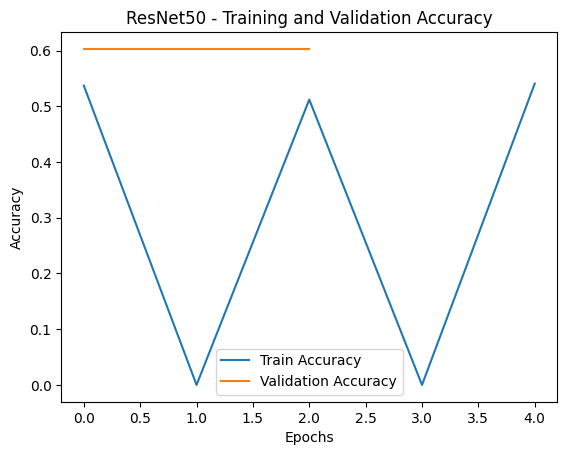

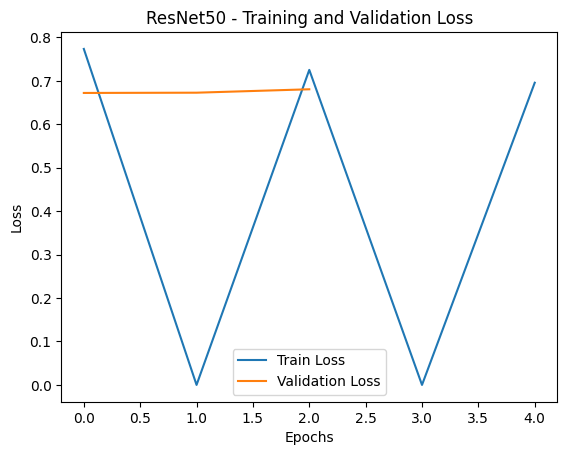

Training EfficientNetB0...
Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 86s 464ms/step - accuracy: 0.5147 - loss: 0.7019 - val_accuracy: 0.6029 - val_loss: 0.6718
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


105/105 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.5124 - loss: 0.7091 - val_accuracy: 0.6029 - val_loss: 0.6755
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 164us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.5929 - loss: 0.6817 - val_accuracy: 0.6029 - val_loss: 0.6778


27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 429ms/step
EfficientNetB0 Results:
Accuracy: 0.6029
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


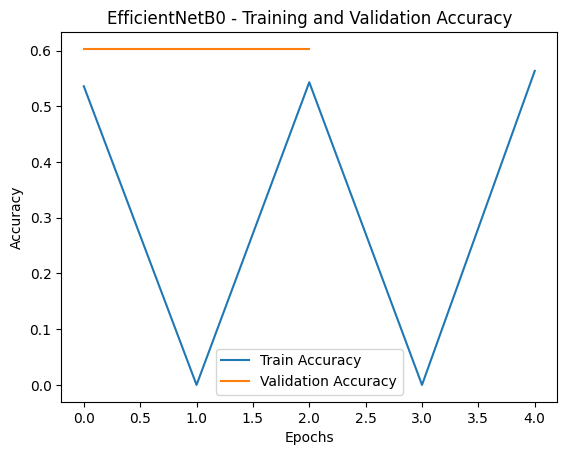

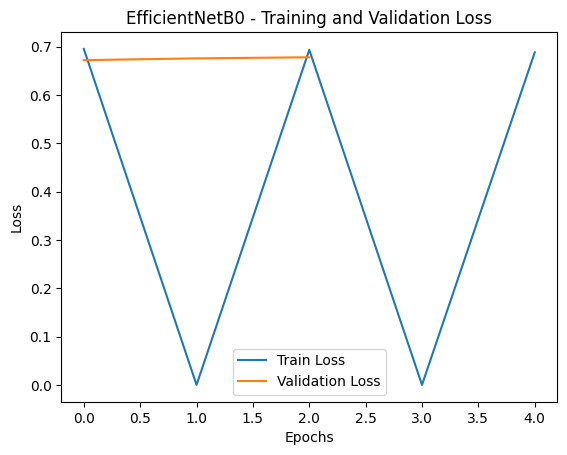

Training MobileNetV2...
Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 232ms/step - accuracy: 0.4926 - loss: 0.9918 - val_accuracy: 0.5885 - val_loss: 0.7236
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.5893 - loss: 0.7064 - val_accuracy: 0.5502 - val_loss: 0.7009
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.5267 - loss: 0.6937 - val_accuracy: 0.5789 - val_loss: 0.6970


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step
MobileNetV2 Results:
Accuracy: 0.6124
Precision: 0.6000
Recall: 0.0723
F1 Score: 0.1290


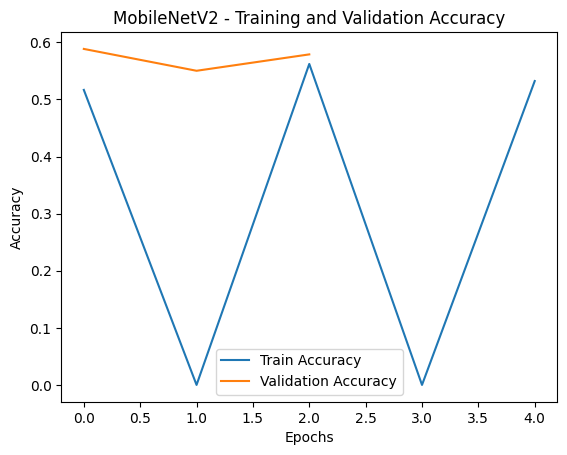

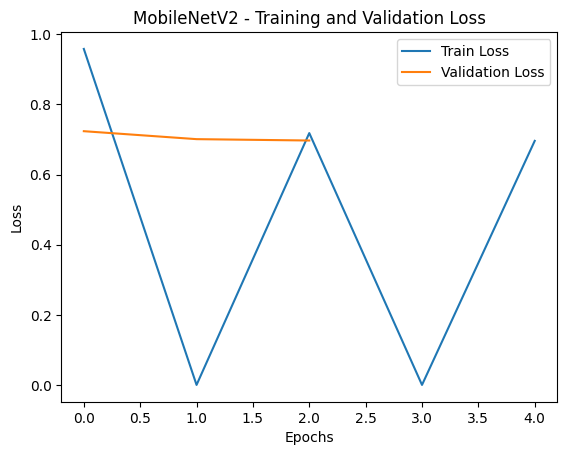

In [20]:
# Step 6: Train and evaluate models
results = {}
for model_name, base_model in models.items():
    print(f"Training {model_name}...")
    model = create_model(base_model)
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,  # Adjust epochs for quick comparisons
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator)
    )

    # Save the model
    model.save(f'{model_name}_fine_tuned_model.h5')

    # Evaluate the model
    val_generator.reset()
    predictions = model.predict(val_generator)
    y_pred = (predictions > 0.5).astype(int)
    y_true = val_df['label'].astype(int).values

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    results[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot training history
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


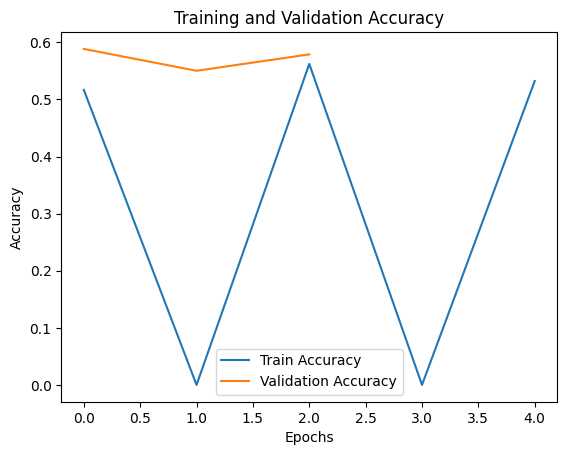

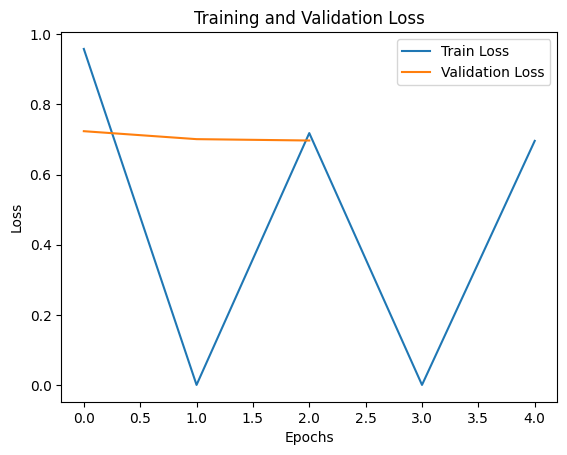

In [21]:
# Step 9: Visualize training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
print("Number of training samples:", len(train_generator))
print("Number of validation samples:", len(val_generator))


Number of training samples: 0
Number of validation samples: 0


In [15]:
print("fotka1 preview:")
print(df['fotka1'].head())

print("\nChecking invalid file paths:")
invalid_paths = df[~df['fotka1'].apply(os.path.isfile)]
print(invalid_paths)


fotka1 preview:
0    [[[0.14509804546833002, 0.15686275064945202, 0...
1    [[[0.14509804546833002, 0.15686275064945202, 0...
2    [[[0.14509804546833002, 0.15686275064945202, 0...
3    [[[0.14509804546833002, 0.15686275064945202, 0...
4    [[[0.7254902124404901, 0.623529434204101, 0.57...
Name: fotka1, dtype: object

Checking invalid file paths:
                                                 fotka1  \
0     [[[0.14509804546833002, 0.15686275064945202, 0...   
1     [[[0.14509804546833002, 0.15686275064945202, 0...   
2     [[[0.14509804546833002, 0.15686275064945202, 0...   
3     [[[0.14509804546833002, 0.15686275064945202, 0...   
4     [[[0.7254902124404901, 0.623529434204101, 0.57...   
...                                                 ...   
1040  [[[0.5725490450859071, 0.47058823704719505, 0....   
1041  [[[0.47843137383461, 0.329411774873733, 0.2470...   
1042  [[[0.47843137383461, 0.329411774873733, 0.2470...   
1043  [[[0.47843137383461, 0.329411774873733, 0.2470...   
10

In [16]:
import numpy as np
from PIL import Image
import os

# Create a directory to store the images
os.makedirs("images", exist_ok=True)

def save_image(img_data, index):
    array = np.array(eval(img_data))  # Convert string to array if necessary
    img = Image.fromarray((array * 255).astype(np.uint8))  # Normalize and convert to uint8
    path = f"images/image_{index}.png"
    img.save(path)
    return path

# Save images and update fotka1 column
df['fotka1'] = [save_image(img, idx) for idx, img in enumerate(df['fotka1'])]


In [17]:
print("Valid paths after saving images:")
print(df['fotka1'].apply(os.path.isfile).sum(), "valid paths")


Valid paths after saving images:
1045 valid paths


In [18]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_generator = data_gen.flow_from_dataframe(
    train_df,
    x_col='fotka1',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = data_gen.flow_from_dataframe(
    val_df,
    x_col='fotka1',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("Number of training samples:", len(train_generator))
print("Number of validation samples:", len(val_generator))


Found 836 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Number of training samples: 27
Number of validation samples: 7
